In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
torch.__version__

'1.13.1'

In [2]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device # 상황에 따라 자주 사용하는 변수 선언

'cuda'

In [3]:
# device 개수 반환
torch.cuda.device_count()

1

# 필요한 함수 정의

In [4]:
def plot_predictions(train_data,            # =X_train
                     train_labels,          # =y_train
                     test_data,             # =X_test
                     test_labels,           # =y_test
                     predictions=None):     # =y_pred
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [5]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 데이터 준비

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


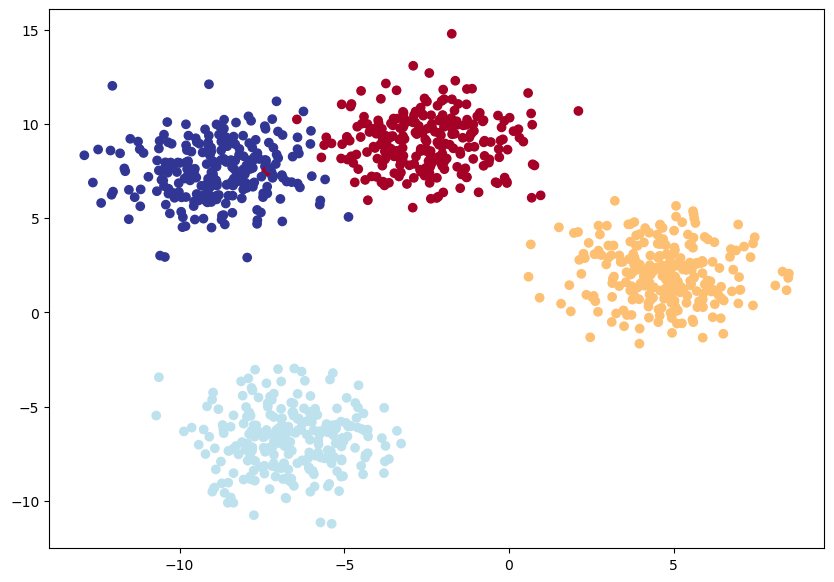

In [6]:
# Import dependencies
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # 왜?
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

# 모델 설계

In [8]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

# loss function, optimizer 설정

In [9]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

# torch.softmax(logits, dim) 사용 예시

In [10]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.5591, -0.7091,  0.5529,  0.4874],
        [ 0.7630,  1.3537, -0.3674,  0.8283],
        [-0.1395,  1.0847, -0.2646, -0.9384],
        [-0.6318, -0.5462,  0.4761,  0.0964],
        [ 0.1822,  0.0705,  0.2108,  1.1861]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1291, 0.1111, 0.3924, 0.3675],
        [0.2383, 0.4303, 0.0770, 0.2544],
        [0.1744, 0.5932, 0.1539, 0.0785],
        [0.1391, 0.1515, 0.4212, 0.2881],
        [0.1769, 0.1582, 0.1821, 0.4828]], device='cuda:0',
       grad_fn=<SliceBackward0>)


# torch.argmax(input) 사용 예시

In [11]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1291, 0.1111, 0.3924, 0.3675], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='cuda:0')


# 모델 학습 및 평가

In [12]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    #! Training
    model_4.train()

    #? 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    
    #? 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #! Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                                y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.77329, Acc: 0.62% | Test Loss: 0.81207, Test Acc: 66.00%
Epoch: 10 | Loss: 0.27777, Acc: 96.38% | Test Loss: 0.23867, Test Acc: 96.50%
Epoch: 20 | Loss: 0.11914, Acc: 99.00% | Test Loss: 0.11029, Test Acc: 99.00%
Epoch: 30 | Loss: 0.07893, Acc: 99.00% | Test Loss: 0.07221, Test Acc: 99.50%
Epoch: 40 | Loss: 0.06164, Acc: 99.00% | Test Loss: 0.05487, Test Acc: 99.50%
Epoch: 50 | Loss: 0.05236, Acc: 99.00% | Test Loss: 0.04526, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04667, Acc: 99.00% | Test Loss: 0.03924, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04288, Acc: 99.00% | Test Loss: 0.03514, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04019, Acc: 99.00% | Test Loss: 0.03219, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03819, Acc: 99.00% | Test Loss: 0.02997, Test Acc: 99.50%


# 모델 평가

In [14]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  5.3901,  10.5360,  -9.4839,  -6.4681],
        [  4.0027, -10.5906,   2.2636,   9.5697],
        [-11.6770, -16.0553,  17.4194,   8.9594],
        [  1.4322,   6.8733,  -4.5072,  -4.8423],
        [ 10.1141,   5.2716, -10.5662,  -0.8971],
        [  4.5288, -13.1493,   3.1374,  11.7278],
        [-11.9068, -13.1951,  16.1593,   6.6585],
        [  8.2221,   1.0045,  -6.9188,   1.8416],
        [-12.2401, -21.0772,  20.3964,  12.6993],
        [  8.7293,   2.5135,  -8.0806,   0.8228]], device='cuda:0')

In [15]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


# 시각화

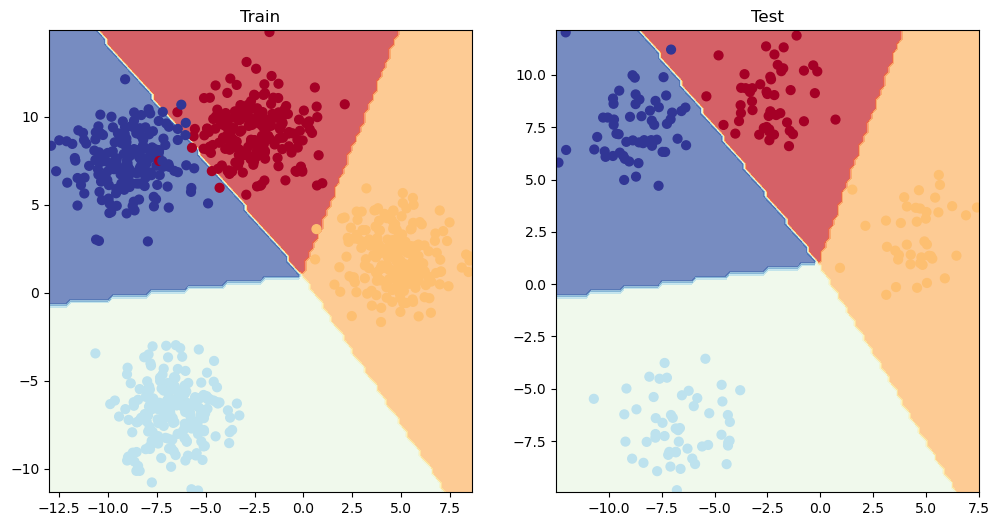

In [16]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)